### Python金融风控策略实战（基于Jupyter Notebook）
## <center>美国 Lending Club 信贷风控数据 >>> 全流程实战</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.12.2</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>   
  
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>   
  
  <font color=blue><center>项目源代码、数据、自定义函数已上传GitHub：</center></font>   
    
   <font color=blue><center>https://github.com/lotbear/Python-Financial-investment-strategy</center></font>


=====================================================================================================================================     

### 第 0 步：数据概况
数据来源：美国 Lending Club 公司官网：     https://www.lendingclub.com/info/statistics.action     

信贷申请数据收录时间：2019年第一季度；   数据格式：csv ，可用 pandas 导入  

<font color=red>必要申明 ! 本报告仅限于 < 金融大数据风控的学术研究 >，不存在任何金融产品或平台的推荐行为。</font>

Lending Club 创始于2006年，其利用互联网技术，形成了一个直接对接投资人与借款人的中介平台（P2P），主要产品包括：无担保个人贷款、消费贷、教育与医疗贷款、面向中小企业的无担保贷款。截止2020年三季末，平台贷款总额超 601亿美金。Lending Club 于2014年12月在纽交所上市。    

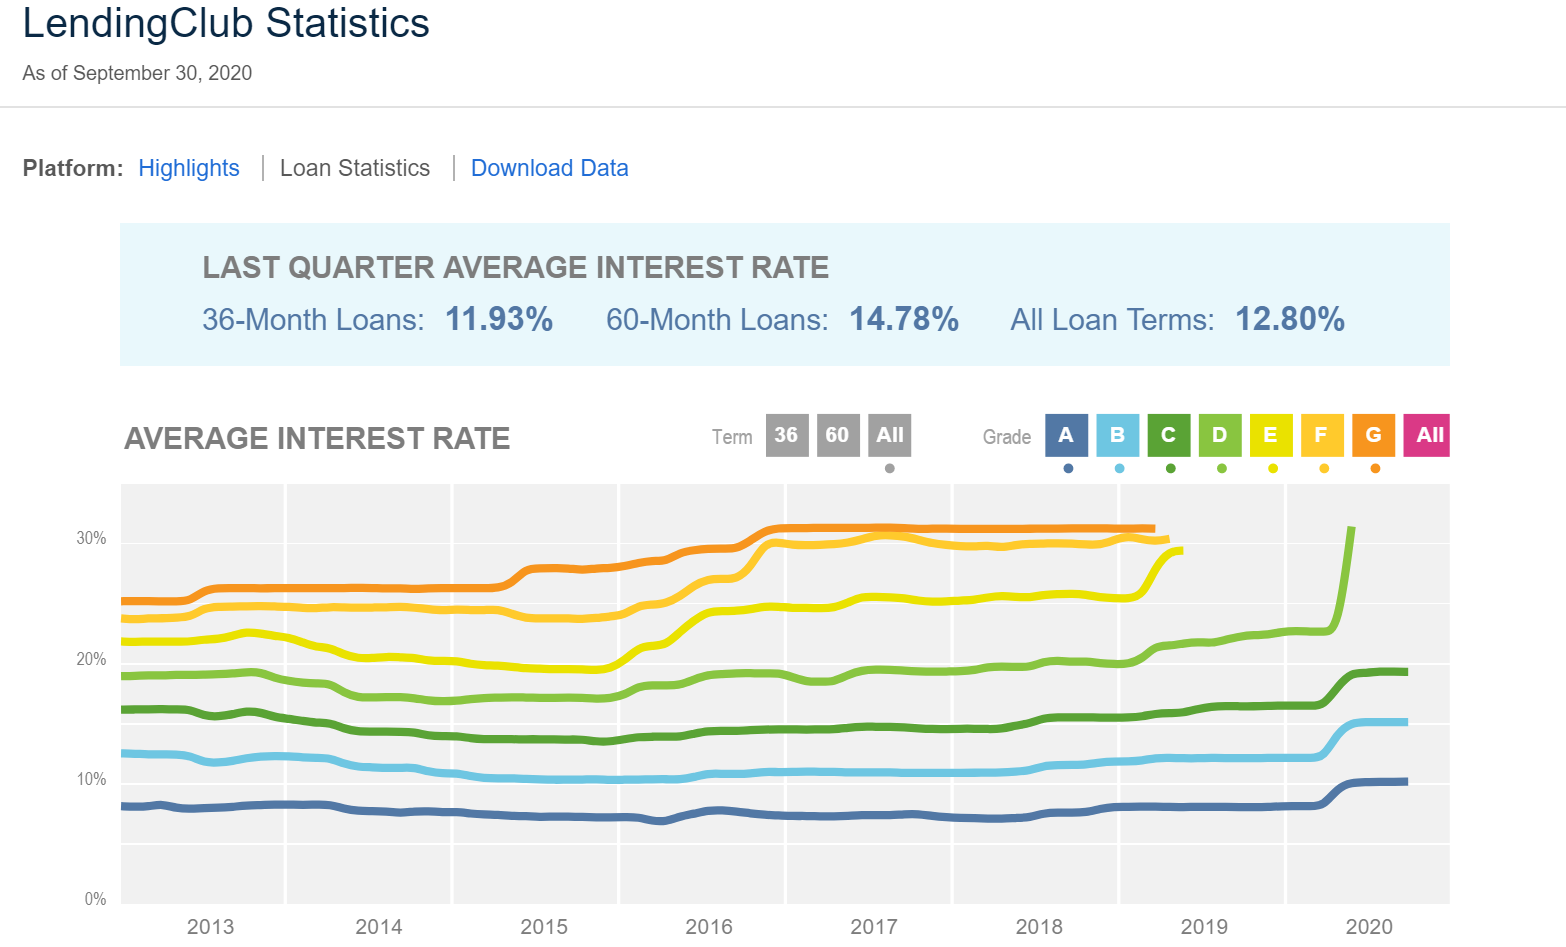

<font color=red>该平台 信贷评估 筛选条件如下：</font>   

1. FICO 分不小于 660分
2. 债务收入比小于35%
3. 最少有2个循环信用账户
4. 提供至少36个月以上的信用记录
5. 6个月内征信查询次数小于5次

只有通过初步筛选，借款人才能进入平台内部的信用评级系统，然后进行申请贷款金额与利率的调整，通过评估后进行授信。与芝麻分类似，<font color=red>FICO 的分数区间为：300分 ~ 850分，分数越高，信用状态越好，更容易拿到较低的贷款利率</font> ，反之亦然。  

FICO 评分模型的局限性：该模型的构建非常依赖于征信数据，虽然央行的征信记录覆盖率在逐年增加，但无信用记录的客户群体还是比较大，且征信记录的更新速度比较慢，而互联网金融的客户群体变化速度较快，因此，FICO 评分模型在国内的应用具有一定的局限性。与此同时，FICO 只适合个人信用评估，不能用做企业级信用评估。

Lending Club 官网贷款统计数据：
https://www.lendingclub.com/info/demand-and-credit-profile.action   

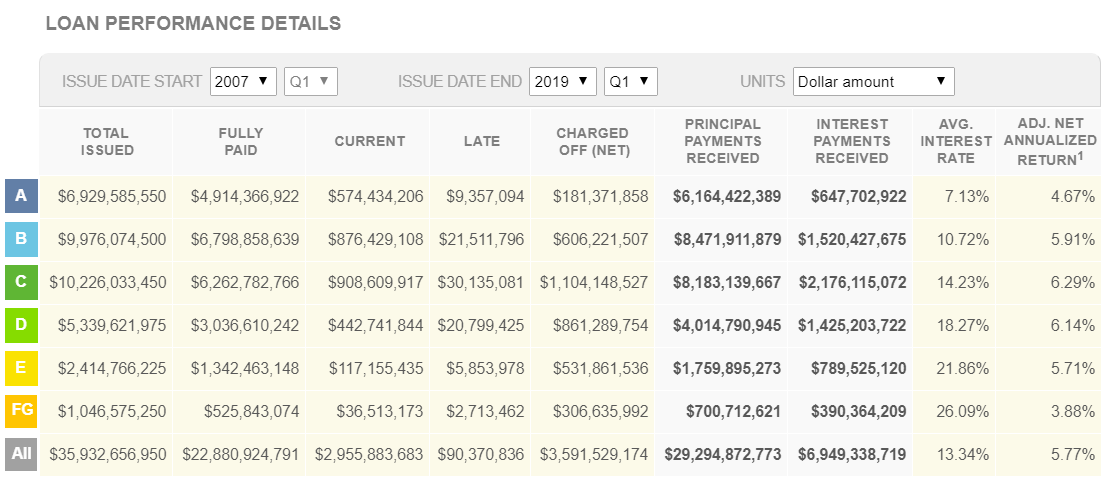

### 第一步：导入需要使用的python库

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") ## 忽略版本警告
from sklearn.model_selection import train_test_split
import time,datetime
import variable_bin_methods as varbin_meth ## 自定义函数，已上传至GitHub同文件夹
import variable_encode as var_encode ## 自定义函数，已上传至GitHub同文件夹
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score,precision_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from feature_selector import FeatureSelector ## 自定义函数，已上传至GitHub同文件夹
from imblearn.over_sampling import SMOTE
import missingno as msno
import matplotlib
matplotlib.use(backend='Qt5Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False  
%matplotlib inline

### 第二步：定义需要的子函数

In [2]:
## 删除缺失值多的样本
def del_na(df,colname_1,rate):
    ## df: dataframe
    ## colname_1: 列名list
    ## rate:缺失值比例，大于rate变量删除
    na_cols = df[colname_1].isna().sum().sort_values(ascending=False)/float(df.shape[0])
    na_del = na_cols[na_cols >= rate]
    df = df.drop(na_del.index, axis=1)
    return df,na_del

In [3]:
## 目标变量映射字典
def target_mapping(lst):
    ## Late (31-120 days)、Default、Charged Off映射为1，坏样本
    ## Late (16-30 days)、In Grace Period映射为2,不确定样本
    ## Current、Fully Paid映射为0，好样本
    mapping = {}
    for elem in lst:
        if elem in ["Charged Off",'Late (16-30 days)', "Late (31-120 days)" ]:
            mapping[elem] = 1
        elif elem in ['In Grace Period']:
            mapping[elem] = 2
        elif elem in ['Current','Fully Paid']:
            mapping[elem] = 0
        else:
            mapping[elem] = 3
    return mapping   

In [4]:
## 删除常量
def constant_del(df, cols):
    dele_list = []
    for col in cols:
        # remove repeat value counts
        uniq_vals = list(df[col].unique())
        if pd.isnull(uniq_vals).any():
            if len( uniq_vals ) == 2:
                dele_list.append(col)
                print (" {} 变量只有一种取值,该变量被删除".format(col))
        elif len(df[col].unique()) == 1:
            dele_list.append(col)  
            print (" {} 变量只有一种取值,该变量被删除".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list

In [5]:
##删除长尾数据
def tail_del(df,cols,rate):
    dele_list = []
    len_1 = df.shape[0]
    for col in cols:
        if len(df[col].unique()) < 5:
            if df[col].value_counts().max()/len_1 >= rate:
                dele_list.append(col)  
                print (" {} 变量分布不均衡,该变量被删除".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list

In [6]:
## 时间格式转化      
def trans_format(time_string, from_format, to_format='%Y.%m.%d'):
    ## from_format:原字符串的时间格式
    ## param to_format:转化后的时间格式
    if pd.isnull(time_string):
        return np.nan
    else:
        time_struct = time.strptime(time_string,from_format)
        times = time.strftime(to_format, time_struct)
        times = datetime.datetime.strptime(times,'%Y-%m')
        return times  

In [7]:
## 离散变量与连续变量区分   
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    ## 先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

In [8]:
## 变量选择：iv筛选
def iv_selection_func(bin_data, data_params, iv_low=0.02, iv_up=5, label='target'):
    # 简单看一下IV，太小的不要
    selected_features = []
    for k, v in data_params.items():
        if iv_low <= v < iv_up and k in bin_data.columns:
            selected_features.append(k+'_woe')
        else:
            print('{0} 变量的IV值为 {1}，小于阈值删除'.format(k, v))
    selected_features.append(label)
    return bin_data[selected_features]

def score_params_cal(base_point, odds, PDO):
    ##给定预期分数，与翻倍分数，确定参数A,B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 

def myfunc(x):
    return str(x[0])+'_'+str(x[1])

In [9]:
## 生成评分卡
def create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin):
    ##假设Odds在1:60时对应的参考分值为600分，分值调整刻度PDO为20，则计算得到分值转化的参数B = 28.85，A= 481.86。
    params_A,params_B = score_params_cal(base_point=600, odds=1/60, PDO=20)
    # 计算基础分
    base_points = round(params_A - params_B * dict_params['intercept'])
    df_score = pd.DataFrame()
    dict_bin_score = {}
    for k in dict_params.keys():
#        k='duration_BIN'
#        k = 'foreign_worker_BIN'
        if k !='intercept':
            df_temp =  pd.DataFrame([dict_woe_map[k.split(sep='_woe')[0]]]).T
            df_temp.reset_index(inplace=True)
            df_temp.columns = ['bin','woe_val']
            ## 计算分值
            df_temp['score'] = round(-params_B*df_temp.woe_val*dict_params[k])
            dict_bin_score[k.split(sep='_BIN')[0]] = dict(zip(df_temp['bin'],df_temp['score']))
            ## 连续变量的计算
            if k.split(sep='_BIN')[0] in dict_cont_bin.keys():
                df_1 = dict_cont_bin[k.split(sep='_BIN')[0]]
                df_1['var_name'] = df_1[['bin_low', 'bin_up']].apply(myfunc,axis=1)
                df_1 = df_1[['total', 'var_name']]
                df_temp = pd.merge(df_temp , df_1,on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)
            ## 离散变量的计算
            elif k.split(sep='_BIN')[0] in dict_disc_bin.keys():
                df_temp = pd.merge(df_temp , dict_disc_bin[k.split(sep='_BIN')[0]],on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)

    df_score['score_base'] =  base_points 
    return df_score,dict_bin_score,params_A,params_B,base_points

In [10]:
## 计算样本分数
def cal_score(df_1,dict_bin_score,dict_cont_bin,dict_disc_bin,base_points):
    ## 先对原始数据分箱映射，然后，用分数字典dict_bin_score映射分数，基础分加每项的分数就是最终得分
    df_1.reset_index(drop=True,inplace = True)
    df_all_score = pd.DataFrame()
    ## 连续变量
    for i in dict_cont_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score , varbin_meth.cont_var_bin_map(df_1[i], dict_cont_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    ## 离散变量
    for i in dict_disc_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score ,varbin_meth.disc_var_bin_map(df_1[i], dict_disc_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    
    df_all_score.columns = [x.split(sep='_BIN')[0] for x in list(df_all_score.columns)]
    df_all_score['base_score'] = base_points    
    df_all_score['score'] = df_all_score.apply(sum,axis=1)
    df_all_score['target'] = df_1.target
    return df_all_score

### 第三步： 数据读取、清洗与预处理
根据 Lending Club 官网下载的数据，2019 年一季度申请个人信贷的样本量 115677个，每个样本均包含 144个变量（字段或属性）。     

根据变量描述，又可分为贷前变量和贷后变量。   

<font color=red>贷前变量</font>又可分为：<font color=red>申请信息类、资质信息类、信用信息类、消费行为变量</font>     

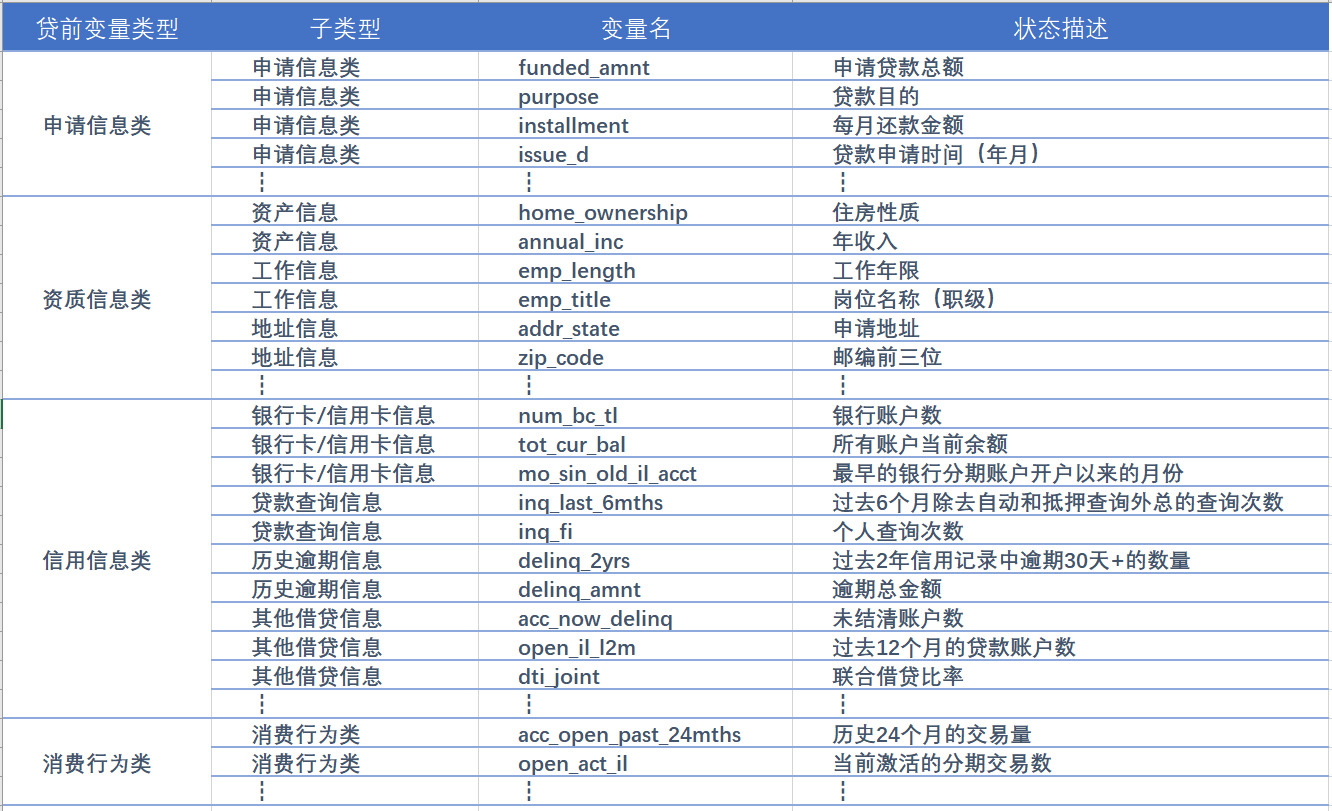     

<font color=red>贷后变量</font>分为标签，即好坏样本与贷后行为信息。   

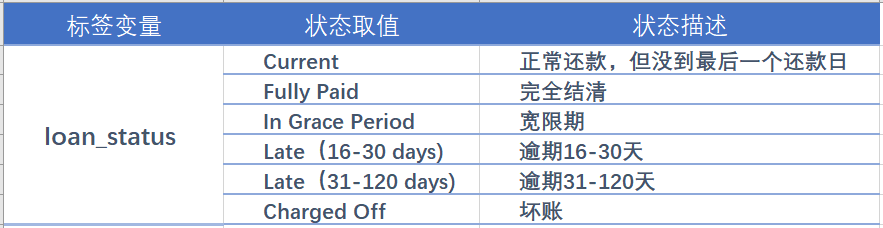

In [11]:
# 用 pandas 读取本地下载好的 csv 格式数据
if __name__ == '__main__':
    data_path = 'C:\\Users\\lotbear\\Desktop\\Data-science！\\金融风控实战数据'
    file_name = 'LoanStats_2019Q1.csv'
    df_1 = pd.read_csv( os.path.join(data_path, file_name),header=1 ,sep=',', low_memory=False)
    raw_columns_list = list(df_1.columns)
print('原始数据样本量:',df_1.shape)
print('='*80)
print('查看原始数据前 5 行：')
df_1.head()

原始数据样本量: (115677, 144)
查看原始数据前 5 行：


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.19%,499.10,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,21225.0,21225.0,21225.0,60 months,14.74%,502.05,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,8.19%,628.49,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,13500.0,13500.0,13500.0,36 months,7.56%,420.31,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
## 好坏样本定义，做贷后标签状态映射
list(df_1["loan_status"].unique()) # 查看标签变量下的状态取值名
print('查看不同 loan_status （贷后状态），样本的分布情况:')
df_1.groupby(["loan_status"])[['int_rate']].count()

查看不同 loan_status （贷后状态），样本的分布情况:


,int_rate
loan_status,
Charged Off,98
Current,110918
Fully Paid,3608
In Grace Period,327
Late (16-30 days),256
Late (31-120 days),468


======================================================================================================================

由于贷后数据中，Lending Club 没有给出每个月详细的还款情况，所以无法用滚动率分析来确定好坏样本，也无法确定具体的表现期。   

#### 本例将逾期 15 天以上的样本定义为 “ 坏信用样本 ” ，逻辑如下：  

1> <font color=red>坏样本</font>，即逾期 15 天以上的样本，在标签变量 loan_status 中取值为：<font color=red>Late (16-30 days)、Late (31-120 days)、Charged Off（坏账）</font>；   

2> <font color=red>不确定样本</font>，即截止到建模阶段，逾期天数不足 15天的样本。需要注意，这些样本不一定是没有到达表现期的样本，而是表现期超出了此刻模型的预测时限，不确定样本在 loan_status 中取值为：<font color=red>In Grace Period </font>宽限期；  

3> <font color=red>好样本</font>，即取值为：<font color=red>Current、Fully Paid</font> 的样本。

In [13]:
df_1.rename(columns={'loan_status':'target'},inplace = True) # 将 loan_status 名称改为 target（目标）
df_1 = df_1.loc[~(df_1.target.isnull()),] # 取出目标变量非空的样本
df_1["target"] = df_1["target"].map(target_mapping(df_1["target"].unique())) # 调用之前定义的子函数，进行好坏样本映射
df_1.target.unique() # 查看映射的取值种类（0和1）
df_1 = df_1.loc[df_1.target<=1,] # 双重确定，取出的样本为目标 target = 0/1 的样本
## 样本不均衡严重
print('好样本 / 坏样本，比值：')
print(sum(df_1.target==0)/df_1.target.sum())

好样本 / 坏样本，比值：
139.32603406326035


In [14]:
## 1.删除贷后数据（非 target 的其余贷后变量）
var_del = [ 'collection_recovery_fee','initial_list_status','last_credit_pull_d','last_pymnt_amnt',
           'last_pymnt_d','next_pymnt_d','out_prncp','out_prncp_inv','recoveries','total_pymnt',
           'total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp','settlement_percentage' ]
df_1 = df_1.drop(var_del, axis=1)

In [15]:
## 2 .删除LC公司信用评估的结果,利率也是LC公司的结果，且利率越高风险越大，也是数据泄露的变量
var_del_1 = ['grade','sub_grade','int_rate']
df_1 = df_1.drop(var_del_1, axis=1)
#    df_1.isnull().any()

In [16]:
print('删除贷后数据、评估数据后，数据样本量：')
df_1.shape

删除贷后数据、评估数据后，数据样本量：


(115348, 126)

查看数据缺失情况


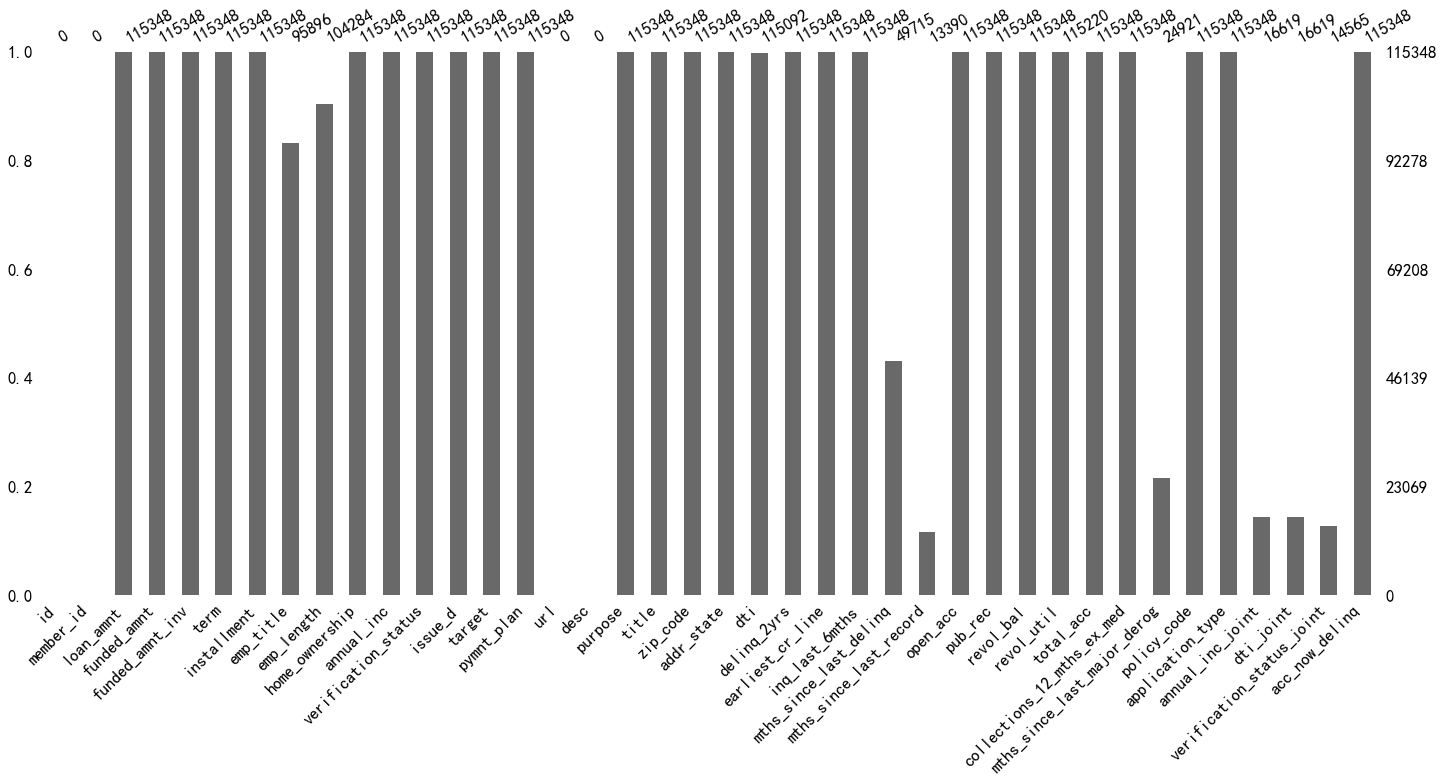

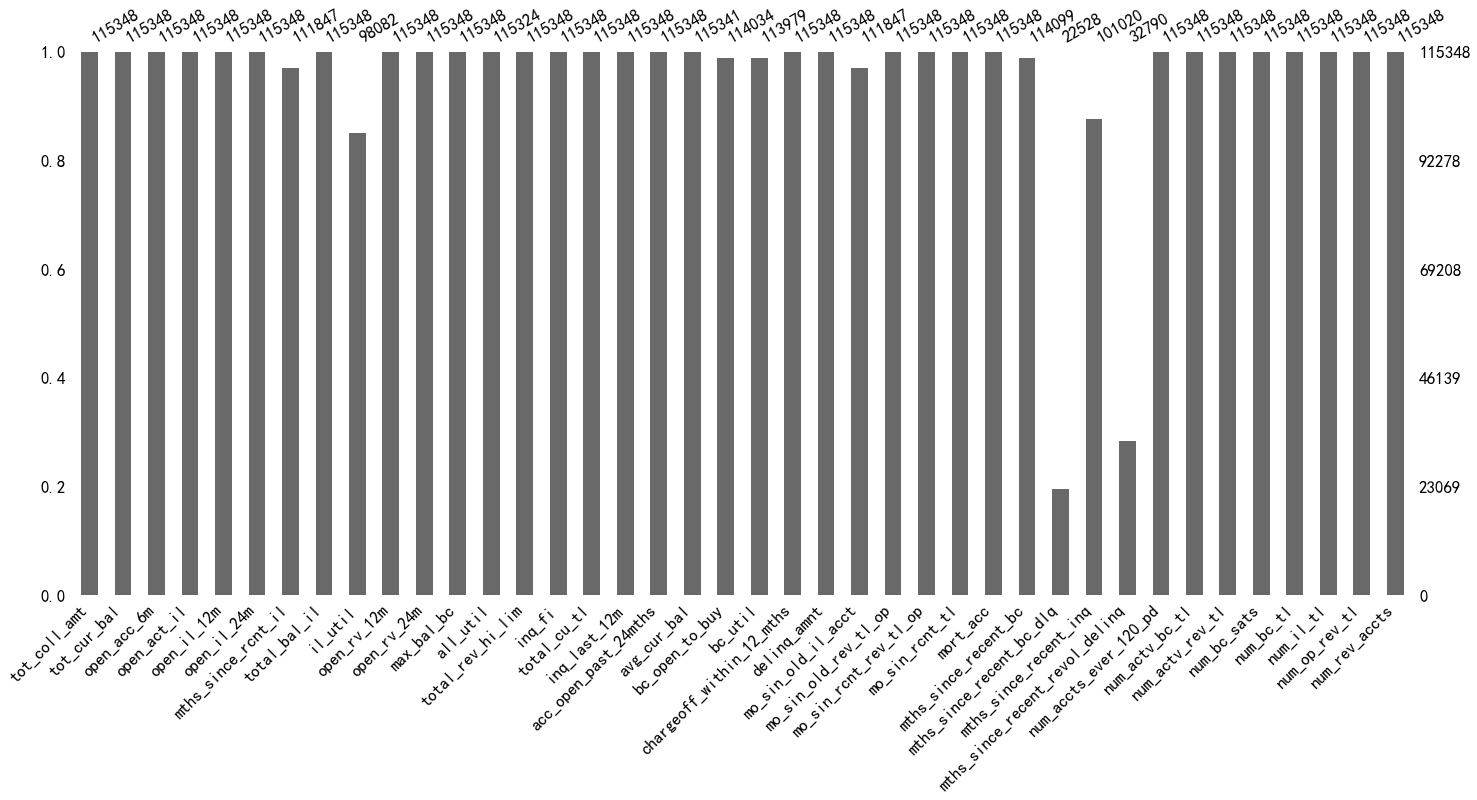

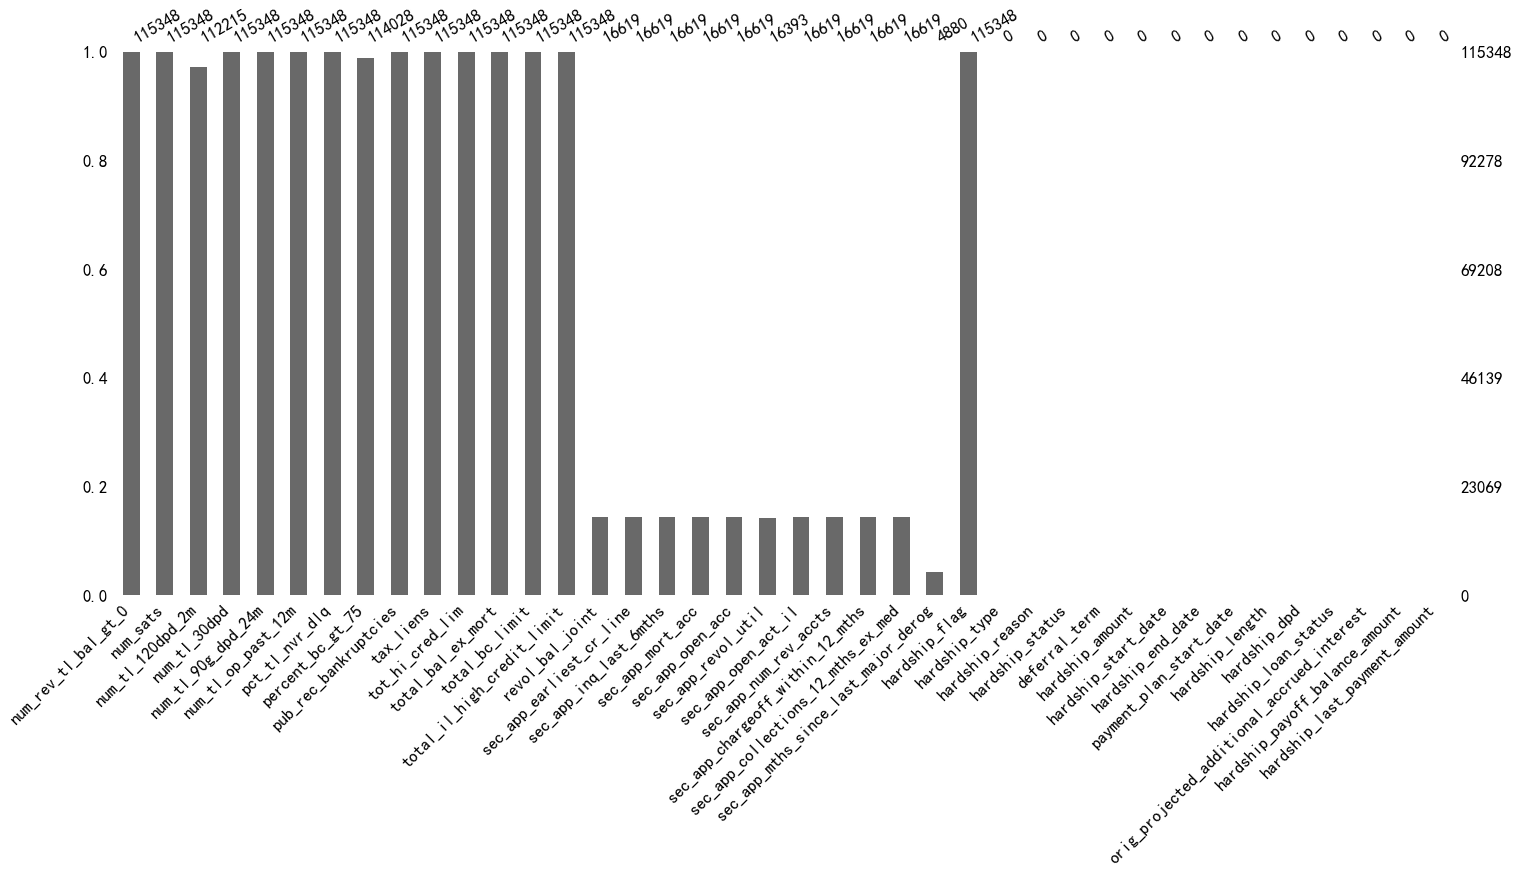

In [17]:
## 3.查看缺失值情况
print('查看数据缺失情况')
## 缺失值绘图
var_list = list(df_1.columns)
for i in range(1,4): # 取值 1,2,3 次循环制图，将 126个变量分层 3*40  显示缺失值
    start = (i-1)*40
    stop = i*40
    plt.figure(figsize=(15,4))
    msno.bar(df_1[var_list[start:stop]],labels=True, fontsize=17)
    plt.xticks(rotation=30,fontsize=17)

In [18]:
## 删除缺失值比率超过 95% 的变量
df_1,na_del = del_na(df_1,list(df_1.columns),rate=0.95) # 调用定义好的子函数
print('删除缺失值比率超过95%的变量,共',len(na_del),'条')
    
## 删除行全为缺失值的本样本
df_1.dropna(axis=0,how='all',inplace=True)
print('删除缺失值后，样本数据量为：',df_1.shape)

删除缺失值比率超过95%的变量,共 24 条
删除缺失值后，样本数据量为： (115348, 102)


In [19]:
## 4.删除只有一种状态的变量
cols_name = list(df_1.columns) 
cols_name.remove('target')
df_1,dele_list = constant_del(df_1, cols_name) # 调用定义好的子函数

 pymnt_plan 变量只有一种取值,该变量被删除
 policy_code 变量只有一种取值,该变量被删除
 acc_now_delinq 变量只有一种取值,该变量被删除
 num_tl_120dpd_2m 变量只有一种取值,该变量被删除
 num_tl_30dpd 变量只有一种取值,该变量被删除
 tax_liens 变量只有一种取值,该变量被删除
 hardship_flag 变量只有一种取值,该变量被删除


In [20]:
## 5.删除长尾数据
cols_name_1 = list(df_1.columns)
cols_name_1.remove('target')
df_1,dele_list = tail_del(df_1,cols_name_1,rate=0.9) # 调用定义好的子函数

 debt_settlement_flag 变量分布不均衡,该变量被删除


In [21]:
## 6.删除一些明显无关的变量
## emp_title工作岗级，可以做一个等级划分，这里直接删除，离散程度较大删除，
## zip_code邮编信息，离散程度太大
## title与purpose一致，直接删除
len(df_1.emp_title.unique())
var_del_2 = ['emp_title','zip_code','title'] # 人为介入，专家经验
df_1 = df_1.drop(var_del_2, axis=1)

In [22]:
## 7.数据格式规范化
## 设置全部显示列信息
pd.set_option('display.max_columns', None)
print('数据格式规范化之前，显示前 5 行：')
df_1.head(5)

数据格式规范化之前，显示前 5 行：


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,target,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med
0,20000.0,20000.0,20000.0,60 months,499.10,6 years,RENT,47000.0,Source Verified,Mar-2019,0,debt_consolidation,CA,14.02,0.0,Sep-2006,1.0,50.0,NaN,15.0,0.0,10687.0,19.7%,53.0,0.0,50.0,Individual,NaN,NaN,NaN,0.0,31546.0,3.0,2.0,1.0,2.0,10.0,20859.0,97.0,4.0,9.0,5909.0,42.0,54300.0,6.0,1.0,3.0,11.0,2103.0,23647.0,30.0,0.0,0.0,150.0,100.0,1.0,1.0,0.0,5.0,NaN,3.0,50.0,3.0,3.0,4.0,8.0,19.0,19.0,13.0,33.0,4.0,15.0,0.0,5.0,98.0,12.5,0.0,75824.0,31546.0,33800.0,21524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21225.0,21225.0,21225.0,60 months,502.05,10+ years,MORTGAGE,225000.0,Not Verified,Mar-2019,0,credit_card,CA,16.80,0.0,Sep-1994,2.0,NaN,110.0,14.0,1.0,95868.0,87.7%,22.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,694793.0,1.0,5.0,2.0,4.0,3.0,113558.0,76.0,0.0,1.0,17353.0,84.0,109300.0,1.0,0.0,4.0,5.0,49628.0,12635.0,76.4,0.0,0.0,126.0,294.0,24.0,3.0,4.0,30.0,NaN,1.0,NaN,0.0,4.0,6.0,4.0,4.0,11.0,7.0,7.0,6.0,14.0,0.0,2.0,100.0,50.0,1.0,747075.0,209426.0,53500.0,128175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000.0,5000.0,5000.0,36 months,180.69,NaN,MORTGAGE,62000.0,Not Verified,Mar-2019,0,home_improvement,FL,19.82,1.0,Nov-1987,0.0,4.0,NaN,8.0,0.0,7285.0,77.5%,18.0,0.0,4.0,Individual,NaN,NaN,NaN,0.0,206639.0,0.0,1.0,0.0,0.0,33.0,24330.0,NaN,1.0,3.0,2318.0,78.0,9400.0,0.0,0.0,0.0,3.0,25830.0,2115.0,77.5,0.0,0.0,187.0,376.0,9.0,9.0,2.0,9.0,NaN,NaN,4.0,3.0,6.0,6.0,6.0,6.0,7.0,6.0,9.0,6.0,8.0,1.0,1.0,66.7,50.0,0.0,255738.0,31615.0,9400.0,39938.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20000.0,20000.0,20000.0,36 months,628.49,1 year,MORTGAGE,200000.0,Not Verified,Mar-2019,0,credit_card,PA,22.66,1.0,Oct-2001,0.0,18.0,NaN,20.0,0.0,20984.0,32.1%,49.0,0.0,48.0,Individual,NaN,NaN,NaN,0.0,326678.0,2.0,5.0,1.0,3.0,4.0,63760.0,61.0,2.0,3.0,5097.0,50.0,64400.0,1.0,5.0,0.0,6.0,17194.0,30437.0,38.4,0.0,0.0,162.0,209.0,2.0,2.0,1.0,2.0,18.0,21.0,18.0,1.0,7.0,9.0,9.0,15.0,20.0,14.0,27.0,9.0,20.0,0.0,3.0,95.7,22.2,0.0,448069.0,84744.0,49400.0,105180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13500.0,13500.0,13500.0,36 months,420.31,8 years,RENT,34860.0,Not Verified,Mar-2019,0,credit_card,AZ,10.91,0.0,Oct-2003,1.0,NaN,NaN,9.0,0.0,9932.0,24.7%,11.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,9932.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,3.0,3777.0,25.0,40200.0,0.0,0.0,1.0,3.0,1104.0,16629.0,33.7,0.0,0.0,NaN,185.0,1.0,1.0,0.0,22.0,NaN,1.0,NaN,0.0,5.0,6.0,5.0,7.0,0.0,9.0,11.0,6.0,9.0,0.0,1.0,100.0,0.0,0.0,40200.0,9932.0,25100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print('数据格式规范化之前，已有的数据类型：')
np.unique(df_1.dtypes)

数据格式规范化之前，已有的数据类型：


array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [24]:
## revol_util数据格式规约
df_1['revol_util']=df_1['revol_util'].str.replace('%','').astype('float')

In [25]:
## 8.日期变量处理
##'sec_app_earliest_cr_line'
var_date = ['issue_d','earliest_cr_line','sec_app_earliest_cr_line' ]
## 时间格式转化
df_1['issue_d'] = df_1['issue_d'].apply(trans_format,args=('%b-%Y','%Y-%m',))
df_1['earliest_cr_line'] = df_1['earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))
df_1['sec_app_earliest_cr_line'] = df_1['sec_app_earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))   

In [26]:
print('查看数据清理后，总数据量：',df_1.shape)
print('='*80)
print('数据格式规范化之后，查看数据前 5 行：')
df_1.head()

查看数据清理后，总数据量： (115348, 91)
数据格式规范化之后，查看数据前 5 行：


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,target,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med
0,20000.0,20000.0,20000.0,60 months,499.10,6 years,RENT,47000.0,Source Verified,2019-03-01,0,debt_consolidation,CA,14.02,0.0,2006-09-01,1.0,50.0,NaN,15.0,0.0,10687.0,19.7,53.0,0.0,50.0,Individual,NaN,NaN,NaN,0.0,31546.0,3.0,2.0,1.0,2.0,10.0,20859.0,97.0,4.0,9.0,5909.0,42.0,54300.0,6.0,1.0,3.0,11.0,2103.0,23647.0,30.0,0.0,0.0,150.0,100.0,1.0,1.0,0.0,5.0,NaN,3.0,50.0,3.0,3.0,4.0,8.0,19.0,19.0,13.0,33.0,4.0,15.0,0.0,5.0,98.0,12.5,0.0,75824.0,31546.0,33800.0,21524.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21225.0,21225.0,21225.0,60 months,502.05,10+ years,MORTGAGE,225000.0,Not Verified,2019-03-01,0,credit_card,CA,16.80,0.0,1994-09-01,2.0,NaN,110.0,14.0,1.0,95868.0,87.7,22.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,694793.0,1.0,5.0,2.0,4.0,3.0,113558.0,76.0,0.0,1.0,17353.0,84.0,109300.0,1.0,0.0,4.0,5.0,49628.0,12635.0,76.4,0.0,0.0,126.0,294.0,24.0,3.0,4.0,30.0,NaN,1.0,NaN,0.0,4.0,6.0,4.0,4.0,11.0,7.0,7.0,6.0,14.0,0.0,2.0,100.0,50.0,1.0,747075.0,209426.0,53500.0,128175.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000.0,5000.0,5000.0,36 months,180.69,NaN,MORTGAGE,62000.0,Not Verified,2019-03-01,0,home_improvement,FL,19.82,1.0,1987-11-01,0.0,4.0,NaN,8.0,0.0,7285.0,77.5,18.0,0.0,4.0,Individual,NaN,NaN,NaN,0.0,206639.0,0.0,1.0,0.0,0.0,33.0,24330.0,NaN,1.0,3.0,2318.0,78.0,9400.0,0.0,0.0,0.0,3.0,25830.0,2115.0,77.5,0.0,0.0,187.0,376.0,9.0,9.0,2.0,9.0,NaN,NaN,4.0,3.0,6.0,6.0,6.0,6.0,7.0,6.0,9.0,6.0,8.0,1.0,1.0,66.7,50.0,0.0,255738.0,31615.0,9400.0,39938.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20000.0,20000.0,20000.0,36 months,628.49,1 year,MORTGAGE,200000.0,Not Verified,2019-03-01,0,credit_card,PA,22.66,1.0,2001-10-01,0.0,18.0,NaN,20.0,0.0,20984.0,32.1,49.0,0.0,48.0,Individual,NaN,NaN,NaN,0.0,326678.0,2.0,5.0,1.0,3.0,4.0,63760.0,61.0,2.0,3.0,5097.0,50.0,64400.0,1.0,5.0,0.0,6.0,17194.0,30437.0,38.4,0.0,0.0,162.0,209.0,2.0,2.0,1.0,2.0,18.0,21.0,18.0,1.0,7.0,9.0,9.0,15.0,20.0,14.0,27.0,9.0,20.0,0.0,3.0,95.7,22.2,0.0,448069.0,84744.0,49400.0,105180.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13500.0,13500.0,13500.0,36 months,420.31,8 years,RENT,34860.0,Not Verified,2019-03-01,0,credit_card,AZ,10.91,0.0,2003-10-01,1.0,NaN,NaN,9.0,0.0,9932.0,24.7,11.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,9932.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,3.0,3777.0,25.0,40200.0,0.0,0.0,1.0,3.0,1104.0,16629.0,33.7,0.0,0.0,NaN,185.0,1.0,1.0,0.0,22.0,NaN,1.0,NaN,0.0,5.0,6.0,5.0,7.0,0.0,9.0,11.0,6.0,9.0,0.0,1.0,100.0,0.0,0.0,40200.0,9932.0,25100.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 第四步：特征工程

In [27]:
## 将时间差值转为月份
df_1['mth_interval']=df_1['issue_d']-df_1['earliest_cr_line']
df_1['sec_mth_interval']=df_1['issue_d']-df_1['sec_app_earliest_cr_line']
    
df_1['mth_interval'] = df_1['mth_interval'].apply(lambda x: round(x.days/30,0))
df_1['sec_mth_interval'] = df_1['sec_mth_interval'].apply(lambda x: round(x.days/30,0))
df_1['issue_m']=df_1['issue_d'].apply(lambda x: x.month)

## 删除原始日期变量
df_1 = df_1.drop(var_date, axis=1)

In [28]:
## 年还款总额占年收入百分比
index_1 = df_1.annual_inc ==0
if sum(index_1) > 0:
    df_1.loc[index_1,'annual_inc'] = 10
df_1['pay_in_rate'] = df_1.installment*12/df_1.annual_inc
index_s1 = (df_1['pay_in_rate'] >=1) & (df_1['pay_in_rate'] <2) 
if sum(index_s1)>0:
    df_1.loc[index_s1,'pay_in_rate'] = 1
index_s2 = df_1['pay_in_rate'] >=2
if sum(index_s2)>0:
    df_1.loc[index_s2,'pay_in_rate'] = 2 
    
## 信用借款账户数与总的账户数比
df_1['credit_open_rate'] = df_1.open_acc/df_1.total_acc
## 周转余额与所有账户余额比
df_1['revol_total_rate'] = df_1.revol_bal/df_1.tot_cur_bal
## 欠款总额和本次借款比
df_1['coll_loan_rate'] = df_1.tot_coll_amt/df_1.installment
index_s3 = df_1['coll_loan_rate'] >=1
if sum(index_s3)>0:
    df_1.loc[index_s3,'coll_loan_rate'] = 1
## 银行卡状态较好的个数与总银行卡数的比
df_1['good_bankcard_rate'] = df_1.num_bc_sats/df_1.num_bc_tl
## 余额大于零的循环账户数与所有循环账户数的比
df_1['good_rev_accts_rate'] = df_1.num_rev_tl_bal_gt_0/df_1.num_rev_accts

### 第五步：变量分箱

In [29]:
## 离散变量与连续变量区分
categorical_var,numerical_var = category_continue_separation(df_1,list(df_1.columns))
print('查看变量中的数据类型，若为浮点数 or 整数，则判定为:数值变量/连续变量，否则为离散变量。')
print('='*80)
print('初步数值变量/连续变量有',len(numerical_var),'个,离散变量有',len(categorical_var),'个')
print('='*80)
print('进一步，数值变量中取值少于 10 种的，我们重新认定为离散变量，如：')
print('='*80)
for s in set(numerical_var):
    if len(df_1[s].unique())<=10:
        print('变量'+s+'可能取值'+str(len(df_1[s].unique())))
        categorical_var.append(s)
        numerical_var.remove(s)
        ## 同时将后加的数值变量转为字符串
        index_1 = df_1[s].isnull()
        if sum(index_1) > 0:
            df_1.loc[~index_1,s] = df_1.loc[~index_1,s].astype('str')
        else:
            df_1[s] = df_1[s].astype('str')

查看变量中的数据类型，若为浮点数 or 整数，则判定为:数值变量/连续变量，否则为离散变量。
初步数值变量/连续变量有 88 个,离散变量有 8 个
进一步，数值变量中取值少于 10 种的，我们重新认定为离散变量，如：
变量issue_m可能取值3
变量pub_rec_bankruptcies可能取值5
变量open_il_12m可能取值7
变量pub_rec可能取值5
变量sec_app_inq_last_6mths可能取值8
变量inq_last_6mths可能取值6
变量collections_12_mths_ex_med可能取值7
变量chargeoff_within_12_mths可能取值6


In [30]:
## 划分测试集与训练集
data_train, data_test = train_test_split(df_1,  test_size=0.2,stratify=df_1.target,random_state=25)
print('训练集中，好信用 / 坏信用，比值：',sum(data_train.target==0)/data_train.target.sum())
print('测试集中，好信用 / 坏信用，比值：',sum(data_test.target==0)/data_test.target.sum())

训练集中，好信用 / 坏信用，比值： 139.2401215805471
测试集中，好信用 / 坏信用，比值： 139.67073170731706


In [31]:
## 连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], data_train.target, method=2, mmin=4, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)
## 离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], data_train.target, method=2, mmin=4,
                                     mmax=10, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)
        
## 删除分箱数只有1个的变量
if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]

In [32]:
## 训练数据分箱
## 连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , varbin_meth.cont_var_bin_map(data_train[i], dict_cont_bin[i]) ], axis = 1)
## 离散变量分箱映射
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , varbin_meth.disc_var_bin_map(data_train[i], dict_disc_bin[i]) ], axis = 1)

## 测试数据分箱
## 连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , varbin_meth.cont_var_bin_map(data_test[i], dict_cont_bin[i]) ], axis = 1)
## 离散变量分箱映射
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , varbin_meth.disc_var_bin_map(data_test[i], dict_disc_bin[i]) ], axis = 1)
    
## 组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

data_train_bin.reset_index(inplace=True,drop=True)
data_test_bin.reset_index(inplace=True,drop=True)

var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

print('训练集变量分箱结果：')
data_train_bin

训练集变量分箱结果：


,loan_amnt_BIN,funded_amnt_BIN,funded_amnt_inv_BIN,installment_BIN,annual_inc_BIN,dti_BIN,delinq_2yrs_BIN,mths_since_last_delinq_BIN,mths_since_last_record_BIN,open_acc_BIN,revol_bal_BIN,revol_util_BIN,total_acc_BIN,mths_since_last_major_derog_BIN,annual_inc_joint_BIN,dti_joint_BIN,tot_coll_amt_BIN,tot_cur_bal_BIN,open_acc_6m_BIN,open_act_il_BIN,open_il_24m_BIN,mths_since_rcnt_il_BIN,total_bal_il_BIN,il_util_BIN,open_rv_12m_BIN,open_rv_24m_BIN,max_bal_bc_BIN,all_util_BIN,total_rev_hi_lim_BIN,inq_fi_BIN,total_cu_tl_BIN,inq_last_12m_BIN,acc_open_past_24mths_BIN,avg_cur_bal_BIN,bc_open_to_buy_BIN,bc_util_BIN,delinq_amnt_BIN,mo_sin_old_il_acct_BIN,mo_sin_old_rev_tl_op_BIN,mo_sin_rcnt_rev_tl_op_BIN,mo_sin_rcnt_tl_BIN,mort_acc_BIN,mths_since_recent_bc_BIN,mths_since_recent_bc_dlq_BIN,mths_since_recent_inq_BIN,mths_since_recent_revol_delinq_BIN,num_accts_ever_120_pd_BIN,num_actv_bc_tl_BIN,num_actv_rev_tl_BIN,num_bc_sats_BIN,num_bc_tl_BIN,num_il_tl_BIN,num_op_rev_tl_BIN,num_rev_accts_BIN,num_rev_tl_bal_gt_0_BIN,num_sats_BIN,num_tl_90g_dpd_24m_BIN,num_tl_op_past_12m_BIN,pct_tl_nvr_dlq_BIN,percent_bc_gt_75_BIN,tot_hi_cred_lim_BIN,total_bal_ex_mort_BIN,total_bc_limit_BIN,total_il_high_credit_limit_BIN,revol_bal_joint_BIN,sec_app_mort_acc_BIN,sec_app_open_acc_BIN,sec_app_revol_util_BIN,sec_app_open_act_il_BIN,sec_app_num_rev_accts_BIN,sec_app_chargeoff_within_12_mths_BIN,sec_app_collections_12_mths_ex_med_BIN,mth_interval_BIN,sec_mth_interval_BIN,pay_in_rate_BIN,credit_open_rate_BIN,revol_total_rate_BIN,coll_loan_rate_BIN,good_bankcard_rate_BIN,good_rev_accts_rate_BIN,term_BIN,emp_length_BIN,home_ownership_BIN,verification_status_BIN,purpose_BIN,addr_state_BIN,application_type_BIN,verification_status_joint_BIN,issue_m_BIN,pub_rec_bankruptcies_BIN,open_il_12m_BIN,pub_rec_BIN,sec_app_inq_last_6mths_BIN,inq_last_6mths_BIN,target
0,4.0,4.0,1.0,4.0,1.0,8.0,1.0,1.0,5.0,3.0,1.0,6.0,4.0,1.0,5.0,6.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,7.0,11.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,5.0,5.0,5.0,11.0,5.0,10.0,7.0,5.0,5.0,3.0,6.0,8.0,4.0,1.0,1.0,4.0,8.0,1,2.0,1,3,2,5,2,4.0,3,1,3,1,3.0,3,0
1,4.0,4.0,1.0,4.0,1.0,1.0,1.0,5.0,5.0,3.0,1.0,3.0,2.0,5.0,5.0,6.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,8.0,3.0,5.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,7.0,1.0,2.0,3.0,1.0,2.0,5.0,3.0,6.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,2.0,8.0,1.0,1.0,1.0,2.0,1.0,5.0,5.0,11.0,5.0,10.0,7.0,5.0,5.0,1.0,6.0,7.0,4.0,4.0,4.0,4.0,1.0,2,3.0,2,2,2,3,2,4.0,2,1,2,1,3.0,2,0
2,4.0,4.0,1.0,6.0,1.0,6.0,1.0,5.0,5.0,3.0,2.0,7.0,7.0,1.0,5.0,6.0,1.0,2.0,1.0,2.0,1.0,5.0,1.0,1.0,3.0,3.0,5.0,6.0,2.0,1.0,1.0,3.0,2.0,2.0,1.0,8.0,1.0,5.0,12.0,2.0,1.0,2.0,3.0,5.0,2.0,6.0,1.0,1.0,3.0,4.0,5.0,2.0,3.0,5.0,5.0,3.0,1.0,1.0,1.0,4.0,2.0,2.0,2.0,2.0,5.0,5.0,11.0,5.0,10.0,7.0,5.0,5.0,5.0,6.0,8.0,4.0,1.0,1.0,4.0,8.0,1,3.0,1,1,2,4,2,4.0,1,1,2,1,3.0,3,0
3,4.0,4.0,1.0,4.0,1.0,8.0,1.0,1.0,5.0,3.0,5.0,7.0,5.0,1.0,5.0,6.0,1.0,8.0,1.0,1.0,1.0,2.0,1.0,8.0,3.0,3.0,8.0,5.0,2.0,1.0,2.0,3.0,2.0,5.0,1.0,8.0,1.0,7.0,7.0,2.0,3.0,2.0,2.0,5.0,2.0,6.0,2.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,1.0,1.0,4.0,4.0,8.0,2.0,2.0,1.0,5.0,5.0,11.0,5.0,10.0,7.0,5.0,5.0,1.0,6.0,7.0,4.0,1.0,1.0,4.0,10.0,2,2.0,1,3,2,5,2,4.0,1,1,2,1,3.0,3,0
4,1.0,1.0,1.0,2.0,4.0,8.0,1.0,1.0,5.0,3.0,2.0,7.0,5.0,5.0,5.0,6.0,1.0,10.0,1.0,3.0,1.0,2.0,3.0,4.0,1.0,1.0,8.0,5.0,2.0,1.0,1.0,2.0,2.0,5.0,1.0,8.0,1.0,6.0,7.0,6.0,7.0,2.0,4.0,5.0,3.0,6.0,1.0,1.0,3.0,3.0,5.0,4.0,3.0,3.0,2.0,3.0,1.0,1.0,4.0,4.0,8.0,2.0,2.0,6.0,5.0,5.0,11.0,5.0,10.0,7.0,5.0,5.0,1.0,6.0,1.0,4.0,1.0,1.0,4.0,8.0,2,5.0,1,2,5,1,2,4.0,1,1,2,1,3.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [33]:
## WOE编码
## 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,
                            data_path,var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')
## 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,
                            data_path,var_all_bin, data_test_bin.target, 'dict_woe_map',flag='test')

### 第六步：特征选择

In [34]:
## IV值初步筛选，选择iv大于等于0.01的变量
df_train_woe = iv_selection_func(df_train_woe,dict_iv_values,iv_low=0.01)
    
## 相关性分析，相关系数即皮尔逊相关系数大于0.8的，删除IV值小的那个变量。
sel_var = list(df_train_woe.columns)
sel_var.remove('target') 
## 循环，变量与多个变量相关系数大于0.8，则每次只删除IV值最小的那个，直到没有大于0.8的变量为止
while True:
    pearson_corr = (np.abs(df_train_woe[sel_var].corr()) >= 0.8)
    if pearson_corr.sum().sum() <= len(sel_var):
        break
    del_var = []
    for i in sel_var:
        var_1 = list(pearson_corr.index[pearson_corr[i]].values)
        if len(var_1)>1 :
            df_temp = pd.DataFrame({'value':var_1,'var_iv':[ dict_iv_values[x.split(sep='_woe')[0]] for x in var_1 ]})
            del_var.extend(list(df_temp.value.loc[df_temp.var_iv == df_temp.var_iv.min(),].values))
    del_var1 = list(np.unique(del_var) )      
    ## 删除这些，相关系数大于0.8的变量
    sel_var = [s for s in sel_var if s not in del_var1]
print('='*80)
print('IV值筛选后，剩余变量个数',len(sel_var),'个；较筛选前少了',95-len(sel_var),'个')

delinq_2yrs_BIN 变量的IV值为 0.006049200724264986，小于阈值删除
inq_fi_BIN 变量的IV值为 0.0046020231049861615，小于阈值删除
total_cu_tl_BIN 变量的IV值为 0.006738227223850163，小于阈值删除
delinq_amnt_BIN 变量的IV值为 0.0007315157277453038，小于阈值删除
num_accts_ever_120_pd_BIN 变量的IV值为 0.006263525697590447，小于阈值删除
num_actv_bc_tl_BIN 变量的IV值为 0.003754911698207453，小于阈值删除
sec_app_chargeoff_within_12_mths_BIN 变量的IV值为 0.0051114312820328585，小于阈值删除
sec_app_collections_12_mths_ex_med_BIN 变量的IV值为 0.004921002145369542，小于阈值删除
term_BIN 变量的IV值为 0.00955899578316686，小于阈值删除
application_type_BIN 变量的IV值为 0.0010743996468552694，小于阈值删除
verification_status_joint_BIN 变量的IV值为 0.0023201260610890262，小于阈值删除
pub_rec_bankruptcies_BIN 变量的IV值为 0.0014898505034533723，小于阈值删除
pub_rec_BIN 变量的IV值为 0.001479362567937924，小于阈值删除
IV值筛选后，剩余变量个数 77 个；较筛选前少了 18 个


In [35]:
#        ## 多重共线筛选，vif 方差膨胀银子筛选
#        df_vif = pd.DataFrame({'value':sel_var,
#                               'vif':[variance_inflation_factor(np.array(df_train_woe[sel_var]), i) for i in range(len(sel_var))]})
#        ## 删除 vif 大于10的变量
#        index_1 = df_vif.vif > 10
#        if sum(index_1)>0:
#            df_vif = df_vif.loc[~index_1,]
#        sel_var = list(df_vif.value)

In [36]:
## 随机森林排序
## 特征选择
fs = FeatureSelector(data = df_train_woe[sel_var], labels = data_train_bin.target)
## 一次性去除所有的不满足特征
fs.identify_all(selection_params = {'missing_threshold': 0.9, 
                                    'correlation_threshold': 0.8, 
                                    'task': 'classification', 
                                    'eval_metric': 'binary_error',
                                    'max_depth':2,
                                    'cumulative_importance': 0.90})
df_train_woe = fs.remove(methods = 'all')
df_train_woe['target'] = data_train_bin.target

0 features with greater than 0.90 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.80.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.00765785	valid_0's binary_logloss: 0.0447499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_error: 0.00635746	valid_0's binary_logloss: 0.0363671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.00628522	valid_0's binary_logloss: 0.038191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_error: 0.0070799	valid_0's binary_logloss: 0.0394312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.

### 第七步：模型训练

In [37]:
print('原始训练集中，好/坏样本比例为',int(sum(data_train.target==0)/data_train.target.sum()),': 1，需要做样本均衡处理')

原始训练集中，好/坏样本比例为 139 : 1，需要做样本均衡处理


<font color=red>SMOTE 样本生成法：</font>    

找到每个少数样本（坏样本）的 K 近邻，构成一个个样本领域，并在这些领域里，按需要的样本正负比例，用随机线性插值法生成新的少数样本（坏样本）。

In [38]:
var_woe_name = list(df_train_woe.columns)
var_woe_name.remove('target')
    
## 随机抽取一些好样本，与坏样本合并，再用 SMOTE 生成一个新的样本训练集
df_temp_normal = df_train_woe[df_train_woe.target==0] # 筛出好样本
df_temp_normal.reset_index(drop=True,inplace=True)
index_1 = np.random.randint( low = 0,high = df_temp_normal.shape[0]-1,size=20000)
index_1 = np.unique(index_1)
# print('在含有',df_train_woe.shape[0],'个样本的训练集中，随机抽取 20000 个 target = 0 的好样本，去重后剩余的随机好样本量为：',len(index_1))

df_temp =  df_temp_normal.loc[index_1]
index_2 = [x for x in range(df_temp_normal.shape[0]) if x not in index_1 ] # 剩余没有被随机抽到的好样本
df_temp_other = df_temp_normal.loc[index_2]
df_temp = pd.concat([df_temp,df_train_woe[df_train_woe.target==1]],axis=0,ignore_index=True)
# print('用剩余好样本 + 坏样本 = 新样本集，样本量为：',df_temp.shape[0])

## 用随机抽取的样本做样本生成
sm_sample_1 = SMOTE(random_state=10,sampling_strategy=1,k_neighbors=5)# kind='borderline1'，ratio=0.5
x_train, y_train = sm_sample_1.fit_resample(df_temp[var_woe_name], df_temp.target)
print('用 SMOTE 在随机样本集中，构建 K=5 的近邻领域，并在其中生成少数样本后，样本总量为：',x_train.shape[0])

## 合并数据
x_train = np.vstack([x_train, np.array(df_temp_other[var_woe_name])])
y_train = np.hstack([y_train, np.array(df_temp_other.target)])

print('最终进行训练的样本集中，好/坏样本比例为',int(sum(y_train==0)/sum(y_train)),': 1')

用 SMOTE 在随机样本集中，构建 K=5 的近邻领域，并在其中生成少数样本后，样本总量为： 35928
最终进行训练的样本集中，好/坏样本比例为 5 : 1


In [39]:
#    var_woe_name = sel_var
#    x_train = df_train_woe[var_woe_name]
#    x_train = np.array(x_train)
#    y_train = np.array(data_train_bin.target)

In [40]:
del_list = []
for s in var_woe_name:
    index_s = df_test_woe[s].isnull()
    if sum(index_s)> 0:
        del_list.extend(list(df_test_woe.index[index_s]))
if len(del_list)>0:
    list_1 = [x for x in list(df_test_woe.index) if x not in del_list ]
    df_test_woe = df_test_woe.loc[list_1]
        
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target.loc[list_1])
else:
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target)

In [41]:
### logistic 逻辑回归模型建模
## 设置待优化的超参数
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1},  {1: 2, 0: 1}, {1: 3, 0: 1}, {1: 5, 0: 1}]}
## 初始化网格搜索
lr_gsearch = GridSearchCV(
        estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
        param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)
## 执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('LR逻辑回归模型最优得分 {0},\n最优参数{1}'.format(lr_gsearch.best_score_,lr_gsearch.best_params_))

## 用最优参数，初始化logistic模型
LR_model = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])
## 训练logistic模型
#    LR_model = LogisticRegression(C=0.01, penalty='l2', solver='saga',
#                                    class_weight={1: 3, 0: 1})
LR_model_fit = LR_model.fit(x_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   28.5s finished


LR逻辑回归模型最优得分 0.4611998465620834,
最优参数{'C': 0.1, 'class_weight': {1: 3, 0: 1}}


In [42]:
## 模型评估
y_pred = LR_model_fit.predict(x_test)
## 计算混淆矩阵与recall、precision
cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('LR 逻辑回归模型的召回率：',recall_value)
print('LR 逻辑回归模型的精准率：',precision_value)
print('LR 逻辑回归模型预测的正确率:',acc)
print('='*80)
print('测试集的混淆矩阵：')
cnf_matrix

LR 逻辑回归模型的召回率： 0.3780487804878049
LR 逻辑回归模型的精准率： 0.01615424700364773
LR 逻辑回归模型预测的正确率: 0.8319029042045947
测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,19130,3776
真实样本为反例,102,62


In [43]:
## 给出概率预测结果
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
## 计算fpr与tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)  
## 计算AR、gini等
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
gini = ar
print('测试集的 AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)
print('测试集的AUC值为:',roc_auc)

测试集的 AR/基尼系数为: 0.36005211117334235
测试集的KS值为: 0.30286398493950883
测试集的AUC值为: 0.6800260555866712


最大KS值: 0.30286398493950883


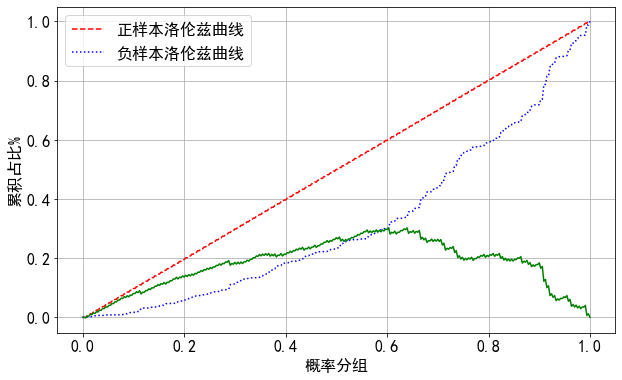

In [44]:
## ks曲线    
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
print('最大KS值:',max(tpr - fpr))

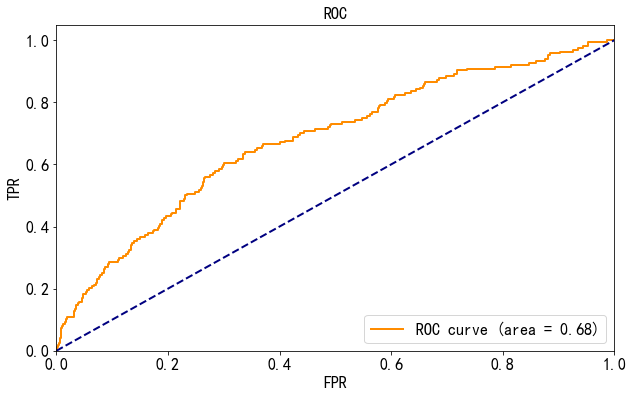

In [45]:
## ROC曲线
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)
plt.title('ROC',fontsize=16)
plt.legend(loc="lower right",fontsize=16)

### 第八步：生成评分卡

In [46]:
## 保存模型的参数用于计算评分
var_woe_name.append('intercept')
## 提取权重
weight_value = list(LR_model_fit.coef_.flatten())
## 提取截距项
weight_value.extend(list(LR_model_fit.intercept_))
dict_params = dict(zip(var_woe_name,weight_value))

In [47]:
## 提取 训练集、测试集 样本分数
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]

In [48]:
## 生成评分卡
df_score,dict_bin_score,params_A,params_B,score_base = create_score(dict_woe_map,
                                                dict_params,dict_cont_bin,dict_disc_bin)
print('参数 A 取值:',params_A)
print('='*80)
print('参数 B 取值:',params_B)
print('='*80)
print('基准分数:',score_base)

参数 A 取值: 481.8621880878296
参数 B 取值: 28.85390081777927
基准分数: 497.0


In [49]:
var_bin_score = pd.DataFrame(dict_bin_score)
print('全部',var_bin_score.shape[1],'个变量，不同取值 bins(分箱) 所对应的分数：')
var_bin_score.sort_index()

全部 55 个变量，不同取值 bins(分箱) 所对应的分数：


,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,mths_since_last_record,revol_bal,revol_util,total_acc,tot_cur_bal,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,sec_app_open_acc,sec_app_revol_util,mth_interval,pay_in_rate,credit_open_rate,coll_loan_rate,good_rev_accts_rate,emp_length,home_ownership,verification_status,purpose,addr_state,issue_m,inq_last_6mths
1.0,0.0,-4.0,1.0,-16.0,-0.0,2.0,4.0,-1.0,-6.0,-4.0,1.0,1.0,1.0,-0.0,-1.0,1.0,-7.0,-3.0,-1.0,-0.0,0.0,0.0,-5.0,-2.0,-6.0,-1.0,-5.0,-1.0,-8.0,-15.0,-3.0,-0.0,5.0,-11.0,-2.0,4.0,2.0,-0.0,-3.0,-1.0,-3.0,7.0,5.0,-0.0,-13.0,-3.0,0.0,-7.0,-7.0,1.0,1.0,-10.0,-10.0,24.0,-2.0
2.0,95.0,2.0,30.0,0.0,159.0,88.0,-2.0,-0.0,0.0,0.0,-12.0,-0.0,-0.0,61.0,-0.0,4.0,-3.0,0.0,-0.0,-1.0,-0.0,-1.0,3.0,-8.0,10.0,-0.0,-1.0,1.0,-3.0,-5.0,1.0,0.0,1.0,-4.0,-1.0,-1.0,185.0,6.0,1.0,1.0,1.0,-19.0,96.0,94.0,20.0,3.0,182.0,-0.0,2.0,-1.0,0.0,0.0,5.0,-1.0,0.0
3.0,-12.0,-8.0,-12.0,26.0,-10.0,-11.0,-59.0,0.0,5.0,20.0,76.0,-7.0,1.0,13.0,1.0,2.0,0.0,1.0,0.0,-0.0,-3.0,11.0,-2.0,-0.0,32.0,1.0,1.0,-3.0,3.0,7.0,0.0,0.0,-2.0,2.0,2.0,-4.0,28.0,0.0,92.0,-2.0,8.0,20.0,-26.0,4.0,-3.0,25.0,-47.0,15.0,7.0,-3.0,-3.0,5.0,26.0,-11.0,-1.0
4.0,23.0,5.0,-6.0,-12.0,10.0,-0.0,2.0,-1.0,-4.0,1.0,79.0,0.0,-1.0,3.0,6.0,-2.0,3.0,-1.0,1.0,0.0,0.0,0.0,4.0,67.0,-10.0,0.0,15.0,36.0,-0.0,-4.0,3.0,0.0,-1.0,5.0,1.0,-2.0,-4.0,0.0,5.0,5.0,3.0,-8.0,-13.0,-9.0,3.0,1.0,-5.0,-4.0,-2.0,NaN,NaN,-6.0,-4.0,NaN,NaN
5.0,4.0,-6.0,NaN,-3.0,-1.0,0.0,4.0,-0.0,1.0,19.0,NaN,1.0,-16.0,-0.0,1.0,-8.0,-2.0,-0.0,1.0,1.0,0.0,-1.0,-1.0,3.0,14.0,-2.0,5.0,31.0,90.0,3.0,-1.0,-0.0,-12.0,-4.0,0.0,-0.0,26.0,-0.0,-9.0,50.0,-1.0,72.0,-0.0,-2.0,21.0,58.0,NaN,2.0,4.0,NaN,NaN,-4.0,11.0,NaN,NaN
6.0,NaN,18.0,NaN,4.0,NaN,NaN,NaN,0.0,-1.0,77.0,NaN,1.0,1.0,-3.0,17.0,-3.0,3.0,1.0,NaN,1.0,-1.0,-1.0,2.0,13.0,36.0,0.0,17.0,-2.0,8.0,NaN,-4.0,-0.0,2.0,16.0,-2.0,NaN,5.0,NaN,6.0,2.0,1.0,-16.0,NaN,NaN,48.0,-6.0,NaN,33.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,-4.0,NaN,33.0,NaN,NaN,NaN,0.0,1.0,3.0,NaN,NaN,-0.0,3.0,NaN,NaN,-5.0,9.0,NaN,NaN,NaN,NaN,7.0,2.0,0.0,NaN,4.0,NaN,-0.0,NaN,3.0,0.0,NaN,-1.0,3.0,NaN,-16.0,NaN,-4.0,-7.0,45.0,7.0,NaN,NaN,-5.0,-3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,7.0,NaN,1.0,NaN,NaN,NaN,-1.0,13.0,1.0,NaN,NaN,NaN,-4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,-8.0,NaN,1.0,NaN,-4.0,NaN,-6.0,1.0,NaN,NaN,0.0,NaN,-2.0,NaN,-1.0,-3.0,-2.0,-29.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,-8.0,NaN,84.0,NaN,NaN,NaN,NaN,-10.0,-13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-9.0,6.0,NaN,NaN,NaN,NaN,NaN,4.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0,24.0,NaN,NaN,24.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,NaN,-6.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
## 计算样本评分
df_all = pd.concat([data_train,data_test],axis = 0)
df_all_score = cal_score(df_all,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
df_all_score.score[df_all_score.score >900] = 900
print('样本最高分：',df_all_score.score.max())
print('样本最低分：',df_all_score.score.min())
print('样本平均分：',df_all_score.score.mean())
print('样本中位数得分：',df_all_score.score.median())
print('='*80)
print('全部样本的变量得分情况：')
df_all_score

样本最高分： 900.0
样本最低分： 350.0
样本平均分： 519.2943787495232
样本中位数得分： 515.0
全部样本的变量得分情况：


,funded_amnt_inv,installment,annual_inc,dti,mths_since_last_delinq,mths_since_last_record,revol_bal,revol_util,total_acc,tot_cur_bal,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,sec_app_open_acc,sec_app_revol_util,mth_interval,pay_in_rate,credit_open_rate,coll_loan_rate,good_rev_accts_rate,emp_length,home_ownership,verification_status,purpose,addr_state,issue_m,inq_last_6mths,base_score,score,target
0,0.0,5.0,1.0,1.0,-0.0,0.0,4.0,0.0,-4.0,0.0,1.0,-0.0,-0.0,3.0,-1.0,1.0,-3.0,0.0,-0.0,-1.0,-0.0,0.0,-2.0,2.0,7.0,1.0,1.0,1.0,3.0,-15.0,1.0,0.0,-2.0,-4.0,-1.0,-1.0,2.0,0.0,1.0,-1.0,-1.0,-1.0,-0.0,4.0,5.0,1.0,0.0,1.0,2.0,1.0,-3.0,0.0,11.0,-11.0,-1.0,497.0,505.0,0
1,0.0,5.0,1.0,-16.0,-1.0,0.0,4.0,0.0,0.0,-4.0,1.0,-0.0,1.0,-4.0,1.0,-8.0,-7.0,-3.0,-0.0,0.0,0.0,0.0,-5.0,2.0,-6.0,-0.0,1.0,-1.0,-3.0,7.0,0.0,0.0,1.0,2.0,-1.0,4.0,-2.0,-0.0,-3.0,1.0,-3.0,-1.0,-0.0,-0.0,-5.0,1.0,-5.0,-7.0,7.0,-1.0,0.0,0.0,26.0,-1.0,0.0,497.0,475.0,0
2,0.0,18.0,1.0,4.0,-1.0,0.0,-2.0,0.0,1.0,0.0,1.0,1.0,1.0,-0.0,1.0,2.0,-2.0,1.0,0.0,-1.0,-0.0,0.0,1.0,3.0,-5.0,-0.0,-5.0,1.0,3.0,-5.0,3.0,-0.0,1.0,2.0,0.0,-0.0,2.0,0.0,1.0,1.0,1.0,-1.0,-0.0,-2.0,5.0,1.0,0.0,1.0,7.0,1.0,1.0,0.0,-4.0,24.0,-1.0,497.0,558.0,0
3,0.0,5.0,1.0,1.0,-0.0,0.0,4.0,0.0,1.0,1.0,1.0,-0.0,1.0,-4.0,1.0,2.0,1.0,-0.0,0.0,-1.0,0.0,0.0,1.0,2.0,0.0,-0.0,1.0,1.0,-3.0,-5.0,0.0,0.0,-2.0,2.0,1.0,-2.0,-4.0,0.0,-1.0,1.0,-3.0,-1.0,-0.0,-0.0,-5.0,1.0,0.0,4.0,2.0,1.0,-3.0,0.0,11.0,24.0,-1.0,497.0,533.0,0
4,0.0,2.0,-6.0,1.0,-0.0,0.0,-2.0,0.0,1.0,-2.0,1.0,-0.0,1.0,3.0,-1.0,1.0,1.0,-0.0,-0.0,-1.0,0.0,0.0,1.0,13.0,0.0,0.0,4.0,1.0,-0.0,7.0,0.0,-0.0,-1.0,2.0,2.0,-1.0,-4.0,0.0,-1.0,1.0,1.0,-1.0,-0.0,-0.0,-13.0,1.0,0.0,1.0,4.0,1.0,0.0,-4.0,-10.0,24.0,-1.0,497.0,523.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115343,0.0,-8.0,1.0,-3.0,-0.0,0.0,-2.0,0.0,-1.0,1.0,1.0,1.0,1.0,-4.0,-0.0,4.0,1.0,0.0,-0.0,-1.0,0.0,-1.0,-1.0,-9.0,-6.0,-0.0,1.0,1.0,-3.0,7.0,-1.0,-0.0,5.0,2.0,0.0,-1.0,-4.0,0.0,-1.0,-3.0,-3.0,-1.0,-0.0,-0.0,5.0,1.0,0.0,-0.0,-7.0,1.0,1.0,0.0,-10.0,-11.0,0.0,497.0,450.0,0
115344,0.0,18.0,1.0,1.0,-1.0,-0.0,-2.0,0.0,-1.0,0.0,1.0,-0.0,-0.0,3.0,-1.0,1.0,3.0,1.0,-1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,1.0,-1.0,8.0,3.0,0.0,0.0,-2.0,2.0,0.0,-2.0,-2.0,0.0,-3.0,1.0,1.0,-1.0,-0.0,-0.0,5.0,1.0,0.0,7.0,-2.0,-1.0,1.0,0.0,11.0,-1.0,0.0,497.0,547.0,0
115345,0.0,-6.0,1.0,1.0,-0.0,0.0,-2.0,0.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,1.0,-2.0,-2.0,-0.0,0.0,1.0,-0.0,0.0,2.0,2.0,7.0,1.0,5.0,-1.0,3.0,7.0,3.0,0.0,-1.0,2.0,1.0,-1.0,2.0,0.0,1.0,1.0,1.0,-1.0,-0.0,94.0,5.0,1.0,0.0,2.0,2.0,-3.0,1.0,0.0,-4.0,-11.0,0.0,497.0,612.0,0
115346,0.0,-8.0,1.0,1.0,-1.0,0.0,4.0,-0.0,5.0,1.0,1.0,-0.0,-1.0,-0.0,-1.0,1.0,-7.0,1.0,-0.0,-1.0,0.0,0.0,-5.0,2.0,0.0,0.0,1.0,1.0,-0.0,7.0,1.0,-0.0,-2.0,-4.0,-1.0,4.0,-2.0,-0.0,-1.0,1.0,1.0,-1.0,-0.0,-0.0,5.0,1.0,-5.0,-0.0,-2.0,1.0,1.0,5.0,-4.0,24.0,0.0,497.0,521.0,0


In [51]:
## 评分卡区间分数统计
good_total = sum(df_all_score.target == 0)
bad_total = sum(df_all_score.target == 1)
score_bin = np.arange(300,950,50)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    ## 取出分数区间的样本
    if score_bin[i+1] == 900:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score < score_bin[i+1]) 
    df_temp = df_all_score.loc[index_1,['target','score']]
    ## 计算该分数区间的指标
    good_num.append(sum(df_temp.target==0))
    bad_num.append(sum(df_temp.target==1))
    ## 区间样本率
    bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
    ## 坏样本率
    bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
    ## 以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )

In [52]:
index_range = ['[ 300-350 )','[ 350-400 )','[ 400-450 )','[ 450-500 )','[ 500-550 )','[ 550-600 ) ','[ 600-650 ) ',
               '[ 650-700 )','[ 700-750 )','[ 750-800 )','[ 800-850 )','[ 850-900 ]']
df_result = pd.DataFrame({'好信用数量':good_num,'坏信用数量':bad_num,'区间样本率':bin_rate,
                            '坏信用率':bad_rate,'KS值(真正率-假正率)':ks},index=index_range)
print('评分卡12个区间分数统计结果如下：')
df_result

评分卡12个区间分数统计结果如下：


,好信用数量,坏信用数量,区间样本率,坏信用率,KS值(真正率-假正率)
[ 300-350 ),0,0,0.000000,NaN,0.000000
[ 350-400 ),56,9,0.056351,13.846154,0.010460
[ 400-450 ),3354,151,3.038631,4.308131,0.164872
[ 450-500 ),34447,437,30.242397,1.252723,0.395724
[ 500-550 ),54004,201,46.992579,0.370815,0.168706
[ 550-600 ),17657,23,15.327531,0.130090,0.042512
[ 600-650 ),3386,0,2.935465,0.000000,0.012946
[ 650-700 ),1084,1,0.940632,0.092166,0.004698
[ 700-750 ),408,0,0.353712,0.000000,0.001135
[ 750-800 ),93,0,0.080626,0.000000,0.000323


In [53]:
score_all = df_all_score.loc[:,['score','target']]
target_0_score = score_all.loc[score_all['target']==0]
target_1_score = score_all.loc[score_all['target']==1]

观察不同分数段中，好坏信用样本频数分布:
好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度


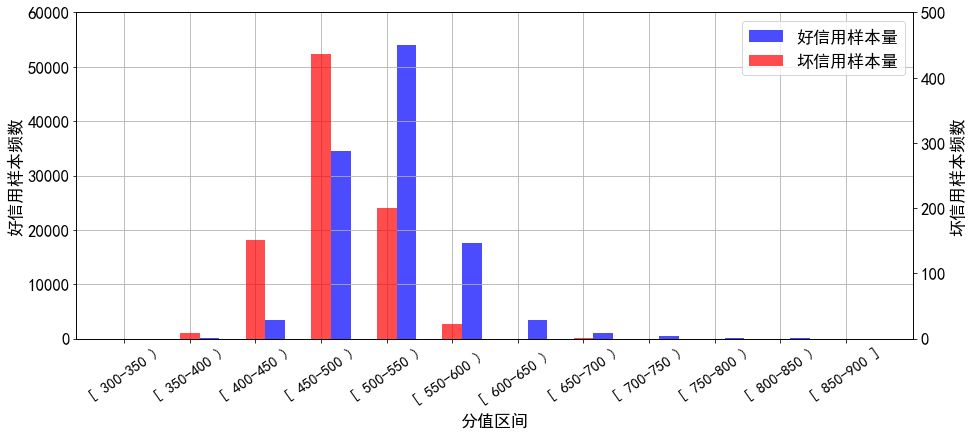

In [54]:
print('观察不同分数段中，好坏信用样本频数分布:\n好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度')

bar_width = 0.3
fig, ax1 = plt.subplots(figsize=(15,6))
plt.bar(np.arange(0,12)+ bar_width,df_result.iloc[:,0],bar_width,alpha=0.7,color='blue', label='好信用样本量') 
ax1.set_ylabel('好信用样本频数',fontsize=17)
ax1.set_ylim([0,60000])
plt.grid(True)
plt.xlabel('分值区间',fontsize=17)
plt.xticks(np.arange(0,12),index_range,rotation=35,fontsize=15)
plt.yticks(fontsize=17)

# 共享横轴，双纵轴
ax2 = ax1.twinx()
ax2.bar(np.arange(0,12),df_result.iloc[:,1],bar_width,alpha=0.7,color='red', label='坏信用样本量')
ax2.set_ylabel('坏信用样本频数',fontsize=17)
ax2.set_ylim([0,500])
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)

# 合并图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='upper right',fontsize=17)
plt.show()

观察不同分数段中，好坏信用样本的概率密度分布：


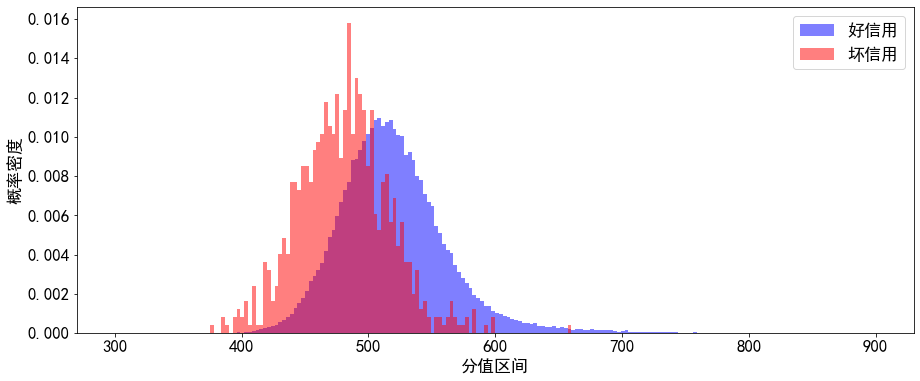

In [55]:
print('观察不同分数段中，好坏信用样本的概率密度分布：')
plt.figure(figsize=(15,6))
plt.hist(target_0_score.iloc[:,0],bins=200,alpha=0.5,label='好信用',
         color='blue',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.hist(target_1_score.iloc[:,0],bins=200,alpha=0.5,label='坏信用',
         color='red',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)
plt.ylabel('概率密度',fontsize=17)
plt.legend(fontsize=17)  
plt.show()